In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from selenium import webdriver  
from selenium.common.exceptions import NoSuchElementException  
from selenium.webdriver.common.keys import Keys  
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
import time
import re
from sys import getsizeof
import os
from sklearn.feature_extraction.text import CountVectorizer
import datetime
now = datetime.datetime.now().time()
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

stops = set(stopwords.words("english"))
_chrome_options = Options()

In [ ]:
# setting this specific options avoids the browser to pop-up requests 
# for saving password and show notifications
pref = {"profile.default_content_setting_values.notifications" : 2, \
       'credentials_enable_service': False, \
        'profile': {'password_manager_enabled': False}}
_chrome_options.add_experimental_option('prefs',pref)

In [ ]:
url = 'https://www.linkedin.com/uas/login?formSignIn=true&amp;\
        session_redirect=%2Fvoyager%2FloginRedirect.html'
driver = webdriver.Chrome(chrome_options=_chrome_options) 
driver.get(url)

# wait for the login elements to load
driver.implicitly_wait(12)

# identify relevant elements
email = driver.find_element_by_name("session_key")
password = driver.find_element_by_css_selector('input[type="password"]')
login = driver.find_element_by_css_selector('input[type="submit"]')

# insert the credentials (you will have to modify this)
email.send_keys('name.lastname@gmail.com') #name.lastname
password.send_keys('password....') #your_password

# login
login.click()

In [ ]:
driver.implicitly_wait(12)
fields = ['Chemical']

for each in fields:    
    print('Surfing for {} Engineering'.format(each))
    job_codes = GetJobCodes(each)
    
    i = 0
    for code in job_codes:
        i +=1
        if (i) % 100 == 0:
            now = datetime.datetime.now().time()
            print("[{:02d}:{:02d}:{:02d}] Scraping posting {}".format(now.hour,now.minute,now.second,i+1))
        driver.get('https://www.linkedin.com/jobs/view/' + code)
        html_source = driver.page_source
        soup = BeautifulSoup(html_source,'html.parser')
    
        with open(r"C:\Users\Fausto\Desktop\Py_Fun\TheDataIncubator\{}\job_{}.txt".format(each, i), "w") as text_file:
            text = soup.prettify()
            print(text.encode("utf-8"), file=text_file)  

### Part II

In [2]:
path = r'C:\Users\Fausto\Desktop\Py_Fun\TheDataIncubator\{}\\'

In [10]:
mec = ProcessFromFolder(path.format('Mechanical'))
opt = ProcessFromFolder(path.format('Optical'))
ele = ProcessFromFolder(path.format('Electrical'))
#che = ProcessFromFolder(path.format('Chemical'))
civ = ProcessFromFolder(path.format('Civil'))

[16:15:31] Processing Folder \Mechanical\\
[16:15:34] Processing record 100
[16:15:37] Processing record 200
[16:15:39] Processing Folder tor\Optical\\
[16:15:42] Processing record 100
[16:15:45] Processing record 200
[16:15:48] Processing record 300
[16:15:50] Processing Folder \Electrical\\
[16:15:53] Processing record 100
[16:15:57] Processing record 200
[16:15:59] Processing Folder bator\Civil\\
[16:16:02] Processing record 100
[16:16:05] Processing record 200
[16:16:08] Processing record 300
[16:16:11] Processing record 400


In [11]:
opt_count = VectorizeCommonWords(opt, 60000)
ele_count = VectorizeCommonWords(ele, 60000)
mec_count = VectorizeCommonWords(mec, 60000)
#che_count = VectorizeCommonWords(che, 60000)
civ_count = VectorizeCommonWords(civ, 60000)

In [12]:
opt_tot = opt_count.sum(axis=0)
ele_tot = ele_count.sum(axis=0)
mec_tot = mec_count.sum(axis=0)
#che_tot = che_count.sum(axis=0)
civ_tot = civ_count.sum(axis=0)

In [13]:
opt_words = set(opt_count.columns)
ele_words = set(ele_count.columns)
mec_words = set(mec_count.columns)
#che_words = set(che_count.columns)
civ_words = set(civ_count.columns)

In [14]:
opt_only = opt_words - ele_words# - mec_words - civ_words# - che_words  
ele_only = ele_words - opt_words# - mec_words - civ_words# - che_words
mec_only = mec_words - opt_words

In [16]:
top_mec = mec_tot[mec_tot.index.isin(mec_only)].sort_values(ascending=False)[:50]
top_ele = ele_tot[ele_tot.index.isin(ele_only)].sort_values(ascending=False)[:50]
top_opt = opt_tot[opt_tot.index.isin(opt_only)].sort_values(ascending=False)[:50]
#top_che = che_tot[che_tot.index.isin(che_only)].sort_values(ascending=False)[:25]
#top_civ = civ_tot[civ_tot.index.isin(civ_only)].sort_values(ascending=False)[:50]

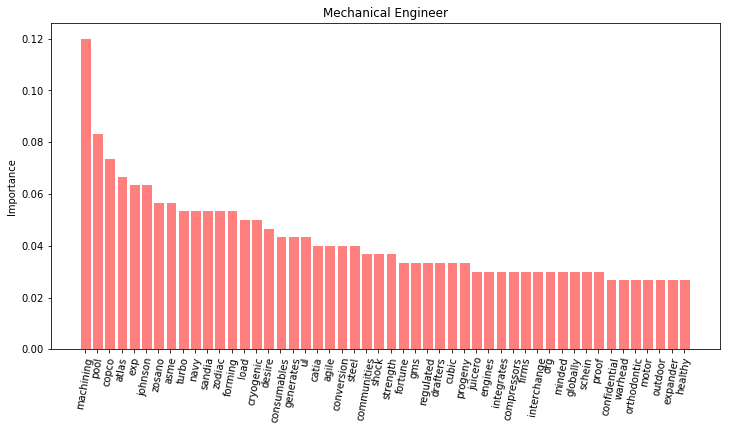

In [17]:
plt.figure(figsize=(12,6))
indexes = np.arange(len(top_mec))
width = 0.8
plt.bar(indexes, top_mec/300, width, color = 'r', alpha = 0.5)
plt.xticks(indexes - width*0.1, top_mec.index, rotation=80)
plt.ylabel('Importance')
plt.title('Mechanical Engineer')
plt.show()

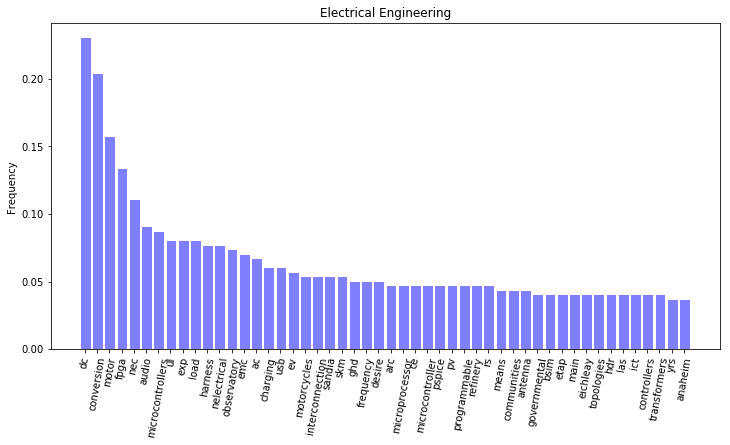

In [18]:
plt.figure(figsize=(12,6))
indexes = np.arange(len(top_ele))
width = 0.8
plt.bar(indexes, top_ele/300, width, color = 'b', alpha = 0.5)
plt.xticks(indexes - width*0.1, top_ele.index, rotation=80)
plt.ylabel('Frequency')
plt.title('Electrical Engineering')
plt.show()

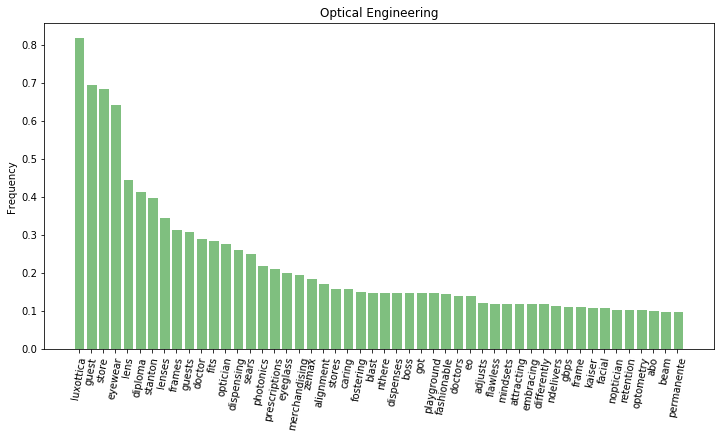

In [19]:
plt.figure(figsize=(12,6))
indexes = np.arange(len(top_opt))
width = 0.8
plt.bar(indexes, top_opt/300, width, color = 'g', alpha = 0.5)
plt.xticks(indexes - width*0.1, top_opt.index, rotation=80)
plt.ylabel('Frequency')
plt.title('Optical Engineering')
plt.show()

In [4]:
def GetJobCodes(field):
    driver.get('https://www.linkedin.com/jobs/search/?keywords={}%20{}&'\
               'location=California'\
               '&locationId=STATES.us.ca'.format(field, 'Engineer')) 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # scrape links from search result page
    html = driver.page_source
    codes = findcodes(html)
    
    job_codes = []
    job_codes.extend(set(links))
    
    morepages = True
    driver.implicitly_wait(12)
    i = 1
    while morepages:
    
        try:
            i += 1
            nextpage = driver.find_element_by_css_selector('button[class="next"]')
            nextpage.click()
            if (i+1) % 5 == 0:
                now = datetime.datetime.now().time()
                print("[{:02d}:{:02d}:{:02d}] Result page {}".format(now.hour,now.minute,now.second,i+1))
            if i == 25:
                morepages = False
            driver.get(driver.current_url)
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            html = driver.page_source
            link = findcodes(html)
            job_codes.extend(set(link))
        except:
            morepages = False
            print('======== TOTAL PAGES = {}'.format(i-1))
            print('======== TOTAL JOBS  = {}'.format(len(job_codes)))
    
    return job_codes

In [5]:
def ProcessFromFolder(path):
    now = datetime.datetime.now().time()
    print("[{:02d}:{:02d}:{:02d}] Processing Folder {}".format(now.hour,now.minute,now.second, path[-13:]))
    processedDescr = dict()
    job_title = dict()
    for i, filename in enumerate(os.listdir(path)):
        if (i+1) % 100 == 0:
            now = datetime.datetime.now().time()
            print("[{:02d}:{:02d}:{:02d}] Processing record {}".format(now.hour,now.minute,now.second,i+1))
        text = open(path + filename, 'r')
        html = text.read()
        title, descr = TitleDescription(html)
        processedDescr[i] = CleanText(descr)
        job_title[i] = title
    df_descr = pd.DataFrame.from_dict(processedDescr, orient="index")
    df_title = pd.DataFrame.from_dict(job_title, orient="index")
        
    df = pd.concat([df_title,df_descr],axis=1)
    df.columns = ['title','ft_words']
    df.index.name = 'job_ID'
    return df

In [6]:
def VectorizeCommonWords(df, num_features):
    """Identifies most common features (first num_features) from a dataframe 
    containing space delimited strings.
    """
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features = num_features)
    vec_words = vectorizer.fit_transform(df["ft_words"])
    vocab = vectorizer.get_feature_names()
    count_vocab = vec_words.toarray()
    count_df = pd.DataFrame(count_vocab, columns=vocab, index=df.index)
    return count_df

In [7]:
def findcodes(html):
    soup = BeautifulSoup(html,'html.parser')
    result_page = soup.prettify()
    jobs = re.findall('(?<=normalized_jobPosting:)[0-9]*',result_page) #normalized_jobPosting: #([\S]*?/jobs/view/[\S]*?)
    
    return jobs

In [8]:
def TitleDescription(html_text):
    title = re.findall('(?<="title":")[\s\S]*?(?=")', html_text)
    description = re.findall('(?<="text":")[\s\S]*?(?=")', html_text)
    
    return title, description[0]

In [9]:
def CleanText(text):
    text = re.sub(r"\n"," ",text)
    text = re.sub(r"[^A-Za-z ]"," ",text)
    text = text.lower()
    text_words = text.split()
    text_words = [w for w in text_words if w not in stops]
    return " ".join(text_words)